In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset

# Load the data
df = pd.read_excel('/Users/jinnanut/Library/Mobile Documents/com~apple~CloudDocs/NUT/Exeter University/Master/Term 3/BEMM466 Business Project/Dissertation/Data/WeeklyData.xlsx')
df['date'] = pd.to_datetime(df['date'])

# Get unique categories
categories = df['category'].unique()

# Create a dictionary to hold results
category_data = {}

# Define 5-week test window
test_window = pd.Timedelta(weeks=5)

# Loop over each category
for cat in categories:
    print(f"\nProcessing category: {cat}")
    
    # Filter and resample weekly
    df_cat = df[df["category"] == cat].copy()
    df_cat = df_cat.set_index('date').sort_index()
    df_cat = df_cat[["quantity"]].resample('W').sum()
    
    # Initialize storage
    category_data[cat] = {"full": df_cat}
    
    # Walk-forward parameters
    start_train = pd.Timestamp("2019-01-01")
    end_of_data = df_cat.index.max()

    split_idx = 1
    test_start = start_train + pd.Timedelta(weeks=52)  # start after 1 year of training
    test_end = test_start + test_window - pd.Timedelta(days=1)

    while test_end <= end_of_data:
        train_start = start_train
        train_end = test_start - pd.Timedelta(days=1)

        train_data = df_cat.loc[train_start:train_end]
        test_data = df_cat.loc[test_start:test_end]

        if train_data.empty or test_data.empty:
            print(f"  Skipping split {split_idx}: empty train or test")
        else:
            category_data[cat][f"train_{split_idx}"] = train_data
            category_data[cat][f"test_{split_idx}"] = test_data
            print(f"  Split {split_idx}: Train = {train_start.date()} to {train_end.date()}, Test = {test_start.date()} to {test_end.date()}")

        # Move test window forward by 5 weeks
        test_start += test_window
        test_end = test_start + test_window - pd.Timedelta(days=1)
        split_idx += 1

# Preview one category’s data
sample_cat = categories[0]
print(f"\nPreview for category '{sample_cat}':")
print(category_data[sample_cat]["full"].head())



Processing category: Furniture
  Split 1: Train = 2019-01-01 to 2019-12-30, Test = 2019-12-31 to 2020-02-03
  Split 2: Train = 2019-01-01 to 2020-02-03, Test = 2020-02-04 to 2020-03-09
  Split 3: Train = 2019-01-01 to 2020-03-09, Test = 2020-03-10 to 2020-04-13
  Split 4: Train = 2019-01-01 to 2020-04-13, Test = 2020-04-14 to 2020-05-18
  Split 5: Train = 2019-01-01 to 2020-05-18, Test = 2020-05-19 to 2020-06-22
  Split 6: Train = 2019-01-01 to 2020-06-22, Test = 2020-06-23 to 2020-07-27
  Split 7: Train = 2019-01-01 to 2020-07-27, Test = 2020-07-28 to 2020-08-31
  Split 8: Train = 2019-01-01 to 2020-08-31, Test = 2020-09-01 to 2020-10-05
  Split 9: Train = 2019-01-01 to 2020-10-05, Test = 2020-10-06 to 2020-11-09
  Split 10: Train = 2019-01-01 to 2020-11-09, Test = 2020-11-10 to 2020-12-14
  Split 11: Train = 2019-01-01 to 2020-12-14, Test = 2020-12-15 to 2021-01-18
  Split 12: Train = 2019-01-01 to 2021-01-18, Test = 2021-01-19 to 2021-02-22
  Split 13: Train = 2019-01-01 to 2021-02

# Monte Carlo Simulation

### Import Essential Tools

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

### 1. Find Seasonal Index & Deseasonalize

In [3]:
# Create dictionary to store seasonality results
seasonality_results = {}

# Loop through each category
for cat in categories:
    print(f"\nProcessing seasonal index for: {cat}")

    if cat not in category_data:
        print(f"  Skipping {cat}: no data.")
        continue

    seasonality_results[cat] = {}

    # Loop through each train split
    for key in category_data[cat]:
        if not key.startswith("train_"):
            continue

        train_df = category_data[cat][key].copy()
        
        # Skip if empty
        if train_df.empty:
            print(f"  Skipping {cat} - {key}: empty train data.")
            continue

        # Step 1: Extract ISO week number (1–52)
        train_df["week"] = train_df.index.isocalendar().week

        # Step 2: Compute weekly seasonal index
        overall_avg = train_df["quantity"].mean()
        weekly_avg = train_df.groupby("week")["quantity"].mean()
        seasonal_index = weekly_avg / overall_avg

        # Step 3: Map seasonal index back to train data
        train_df["seasonal_index"] = train_df["week"].map(seasonal_index)

        # Step 4: Deseasonalize (avoid division by zero)
        train_df["deseasonalized"] = train_df["quantity"] / train_df["seasonal_index"].replace(0, np.nan)
        train_df.dropna(subset=["deseasonalized"], inplace=True)

        # Store results
        seasonality_results[cat][key] = {
            "seasonal_index": seasonal_index,
            "deseasonalized_train": train_df
        }

        print(f"  Done {cat} - {key}: {len(train_df)} points deseasonalized.")




Processing seasonal index for: Furniture
  Done Furniture - train_1: 28 points deseasonalized.
  Done Furniture - train_2: 32 points deseasonalized.
  Done Furniture - train_3: 36 points deseasonalized.
  Done Furniture - train_4: 39 points deseasonalized.
  Done Furniture - train_5: 43 points deseasonalized.
  Done Furniture - train_6: 46 points deseasonalized.
  Done Furniture - train_7: 48 points deseasonalized.
  Done Furniture - train_8: 51 points deseasonalized.
  Done Furniture - train_9: 54 points deseasonalized.
  Done Furniture - train_10: 59 points deseasonalized.
  Done Furniture - train_11: 62 points deseasonalized.
  Done Furniture - train_12: 65 points deseasonalized.
  Done Furniture - train_13: 68 points deseasonalized.
  Done Furniture - train_14: 71 points deseasonalized.
  Done Furniture - train_15: 79 points deseasonalized.
  Done Furniture - train_16: 83 points deseasonalized.
  Done Furniture - train_17: 89 points deseasonalized.
  Done Furniture - train_18: 95 

### 2. Fit Trend Models & Select the Best model

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Create dictionary to store trend model results
trend_results = {}

for cat in seasonality_results:
    print(f"\nFitting trend models for category: {cat}")
    trend_results[cat] = {}

    for train_key in seasonality_results[cat]:
        if not train_key.startswith("train_"):
            continue

        train_df = seasonality_results[cat][train_key]["deseasonalized_train"]

        # Skip if insufficient data points
        if len(train_df) < 5:
            print(f"  Skipping {cat} - {train_key}: too few points ({len(train_df)})")
            continue

        print(f"  Fitting models for: {train_key} ({len(train_df)} points)")
        
        y = train_df["deseasonalized"].values
        X = np.arange(len(y)).reshape(-1, 1)

        models = {}

        # Linear Regression
        lin_model = LinearRegression().fit(X, y)
        lin_pred = lin_model.predict(X)
        models["linear"] = {
            "pred": lin_pred,
            "rmse": mean_squared_error(y, lin_pred, squared=False),
            "mae": mean_absolute_error(y, lin_pred)
        }

        # Polynomial Degree 2
        try:
            poly2 = PolynomialFeatures(degree=2)
            X_poly2 = poly2.fit_transform(X)
            poly2_model = LinearRegression().fit(X_poly2, y)
            poly2_pred = poly2_model.predict(X_poly2)
            models["poly2"] = {
                "pred": poly2_pred,
                "rmse": mean_squared_error(y, poly2_pred, squared=False),
                "mae": mean_absolute_error(y, poly2_pred)
            }
        except Exception as e:
            print(f"    Poly2 failed: {e}")

        # Polynomial Degree 3
        try:
            poly3 = PolynomialFeatures(degree=3)
            X_poly3 = poly3.fit_transform(X)
            poly3_model = LinearRegression().fit(X_poly3, y)
            poly3_pred = poly3_model.predict(X_poly3)
            models["poly3"] = {
                "pred": poly3_pred,
                "rmse": mean_squared_error(y, poly3_pred, squared=False),
                "mae": mean_absolute_error(y, poly3_pred)
            }
        except Exception as e:
            print(f"    Poly3 failed: {e}")

        # Exponential (log-linear)
        try:
            mask = y > 0
            if mask.sum() >= 5:  # Ensure enough positive values
                y_log = np.log(y[mask])
                X_log = X[mask]
                exp_model = LinearRegression().fit(X_log, y_log)
                exp_pred = np.exp(exp_model.predict(X))
                models["exponential"] = {
                    "pred": exp_pred,
                    "rmse": mean_squared_error(y, exp_pred, squared=False),
                    "mae": mean_absolute_error(y, exp_pred)
                }
            else:
                print(f"    Skipping exponential: not enough positive values")
        except Exception as e:
            print(f"    Exponential model failed: {e}")

        if not models:
            print(f"    No valid models for {cat} - {train_key}")
            continue

        # Select best model based on RMSE
        best_model_name = min(models, key=lambda k: models[k]["rmse"])
        best_model_pred = models[best_model_name]["pred"]
        best_rmse = models[best_model_name]["rmse"]

        # Store model results
        trend_results[cat][train_key] = {
            "best_model": best_model_name,
            "prediction": best_model_pred,
            "rmse": best_rmse,
            "all_models": models
        }

        print(f"    Best model: {best_model_name} (RMSE: {best_rmse:.2f})")



Fitting trend models for category: Furniture
  Fitting models for: train_1 (28 points)
    Best model: linear (RMSE: 0.00)
  Fitting models for: train_2 (32 points)
    Best model: poly3 (RMSE: 3.33)
  Fitting models for: train_3 (36 points)
    Best model: poly3 (RMSE: 3.57)
  Fitting models for: train_4 (39 points)
    Best model: poly3 (RMSE: 3.76)
  Fitting models for: train_5 (43 points)
    Best model: poly3 (RMSE: 4.22)
  Fitting models for: train_6 (46 points)
    Best model: poly3 (RMSE: 5.32)
  Fitting models for: train_7 (48 points)
    Best model: poly3 (RMSE: 5.56)
  Fitting models for: train_8 (51 points)
    Best model: poly3 (RMSE: 6.16)
  Fitting models for: train_9 (54 points)
    Best model: poly3 (RMSE: 6.07)
  Fitting models for: train_10 (59 points)
    Best model: poly3 (RMSE: 6.83)
  Fitting models for: train_11 (62 points)
    Best model: poly3 (RMSE: 6.87)
  Fitting models for: train_12 (65 points)
    Best model: poly3 (RMSE: 6.73)
  Fitting models for: trai

### 3. Generate Residual-Based Noise for Monte Carlo

In [5]:
import numpy as np

# Create dictionary to store Monte Carlo inputs
montecarlo_inputs = {}

# Number of simulations
n_simulations = 1000

for cat in trend_results:
    print(f"\nGenerating Monte Carlo inputs for category: {cat}")
    montecarlo_inputs[cat] = {}

    for train_key in trend_results[cat]:
        if train_key not in seasonality_results[cat]:
            print(f"  Skipping {train_key}: missing seasonality data.")
            continue

        y_actual = seasonality_results[cat][train_key]["deseasonalized_train"]["deseasonalized"].values
        y_pred = trend_results[cat][train_key]["prediction"]

        # Check that lengths match
        if len(y_actual) != len(y_pred):
            print(f"  Skipping {train_key}: length mismatch (actual: {len(y_actual)}, pred: {len(y_pred)})")
            continue

        # Step 1: Residuals
        residuals = y_actual - y_pred

        # Step 2: Std deviation of residuals
        residual_std = np.std(residuals)

        # Step 3: Simulated noise (n_samples x n_simulations)
        simulated_errors = np.random.normal(loc=0, scale=residual_std, size=(len(y_actual), n_simulations))

        # Step 4: Store inputs
        montecarlo_inputs[cat][train_key] = {
            "simulated_errors": simulated_errors,
            "residual_std": residual_std,
            "residuals": residuals
        }

        print(f"  {train_key}: residual std = {residual_std:.2f}, shape = {simulated_errors.shape}")



Generating Monte Carlo inputs for category: Furniture
  train_1: residual std = 0.00, shape = (28, 1000)
  train_2: residual std = 3.33, shape = (32, 1000)
  train_3: residual std = 3.57, shape = (36, 1000)
  train_4: residual std = 3.76, shape = (39, 1000)
  train_5: residual std = 4.22, shape = (43, 1000)
  train_6: residual std = 5.32, shape = (46, 1000)
  train_7: residual std = 5.56, shape = (48, 1000)
  train_8: residual std = 6.16, shape = (51, 1000)
  train_9: residual std = 6.07, shape = (54, 1000)
  train_10: residual std = 6.83, shape = (59, 1000)
  train_11: residual std = 6.87, shape = (62, 1000)
  train_12: residual std = 6.73, shape = (65, 1000)
  train_13: residual std = 7.55, shape = (68, 1000)
  train_14: residual std = 8.13, shape = (71, 1000)
  train_15: residual std = 9.50, shape = (79, 1000)
  train_16: residual std = 10.28, shape = (83, 1000)
  train_17: residual std = 10.68, shape = (89, 1000)
  train_18: residual std = 11.15, shape = (95, 1000)
  train_19: res

### 4. Reintroduce Seasonality

In [6]:
# Create a dictionary to store simulation results
simulated_demands = {}

for cat in trend_results:
    print(f"\nReintroducing seasonality for category: {cat}")
    simulated_demands[cat] = {}

    for train_key in trend_results[cat]:
        # Ensure matching seasonal + simulation input exists
        if train_key not in seasonality_results[cat] or train_key not in montecarlo_inputs[cat]:
            print(f"  Skipping {train_key}: missing seasonality or simulation input")
            continue

        # Fetch data
        seasonal_factors = seasonality_results[cat][train_key]["deseasonalized_train"]["seasonal_index"].values.reshape(-1, 1)
        trend_pred = trend_results[cat][train_key]["prediction"].reshape(-1, 1)
        simulated_errors = montecarlo_inputs[cat][train_key]["simulated_errors"]

        # Step 1: Simulate deseasonalized + noise
        simulated_deseasonalized = trend_pred + simulated_errors

        # Step 2: Reintroduce seasonality
        simulated_with_seasonality = simulated_deseasonalized * seasonal_factors

        # Step 3: Store results
        simulated_demands[cat][train_key] = {
            "simulated_demand": simulated_with_seasonality,  # shape: (n_timesteps, n_simulations)
            "index": seasonality_results[cat][train_key]["deseasonalized_train"].index
        }

        print(f"  {train_key}: simulated shape = {simulated_with_seasonality.shape}")



Reintroducing seasonality for category: Furniture
  train_1: simulated shape = (28, 1000)
  train_2: simulated shape = (32, 1000)
  train_3: simulated shape = (36, 1000)
  train_4: simulated shape = (39, 1000)
  train_5: simulated shape = (43, 1000)
  train_6: simulated shape = (46, 1000)
  train_7: simulated shape = (48, 1000)
  train_8: simulated shape = (51, 1000)
  train_9: simulated shape = (54, 1000)
  train_10: simulated shape = (59, 1000)
  train_11: simulated shape = (62, 1000)
  train_12: simulated shape = (65, 1000)
  train_13: simulated shape = (68, 1000)
  train_14: simulated shape = (71, 1000)
  train_15: simulated shape = (79, 1000)
  train_16: simulated shape = (83, 1000)
  train_17: simulated shape = (89, 1000)
  train_18: simulated shape = (95, 1000)
  train_19: simulated shape = (101, 1000)
  train_20: simulated shape = (107, 1000)
  train_21: simulated shape = (110, 1000)
  train_22: simulated shape = (118, 1000)
  train_23: simulated shape = (121, 1000)
  train_24

### 5. Aggregate & Summarize Simulated Demand

In [7]:
monthly_summary = {}

for cat in simulated_demands:
    print(f"\nAggregating monthly simulated demand for: {cat}")
    monthly_summary[cat] = {}

    for train_key in simulated_demands[cat]:
        sim_demand = simulated_demands[cat][train_key]["simulated_demand"]
        index = simulated_demands[cat][train_key]["index"]

        # Create DataFrame of simulations with date index
        sim_df = pd.DataFrame(sim_demand, index=index)

        # Step 1: Resample weekly → monthly (sum per simulation column)
        sim_monthly = sim_df.resample('W').sum()

        # Step 2: Aggregate statistics across simulations (columns)
        mean_forecast = sim_monthly.mean(axis=1)
        p10 = sim_monthly.quantile(0.10, axis=1)
        p90 = sim_monthly.quantile(0.90, axis=1)

        # Step 3: Store result
        monthly_summary[cat][train_key] = pd.DataFrame({
            "mean_forecast": mean_forecast,
            "p10": p10,
            "p90": p90
        })

        print(f"  {train_key}: {len(mean_forecast)} monthly points aggregated")



Aggregating monthly simulated demand for: Furniture
  train_1: 50 monthly points aggregated
  train_2: 57 monthly points aggregated
  train_3: 62 monthly points aggregated
  train_4: 67 monthly points aggregated
  train_5: 72 monthly points aggregated
  train_6: 76 monthly points aggregated
  train_7: 80 monthly points aggregated
  train_8: 85 monthly points aggregated
  train_9: 92 monthly points aggregated
  train_10: 97 monthly points aggregated
  train_11: 102 monthly points aggregated
  train_12: 107 monthly points aggregated
  train_13: 112 monthly points aggregated
  train_14: 116 monthly points aggregated
  train_15: 122 monthly points aggregated
  train_16: 127 monthly points aggregated
  train_17: 132 monthly points aggregated
  train_18: 137 monthly points aggregated
  train_19: 142 monthly points aggregated
  train_20: 147 monthly points aggregated
  train_21: 151 monthly points aggregated
  train_22: 157 monthly points aggregated
  train_23: 162 monthly points aggregated


### 6. Ploting Graph to Analysis


Combining and plotting all splits for: Furniture


/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_actual = pd.concat([all_actual, actual])
/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_mean = pd.concat([all_mean, summary["mean_forecast"]])
/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no

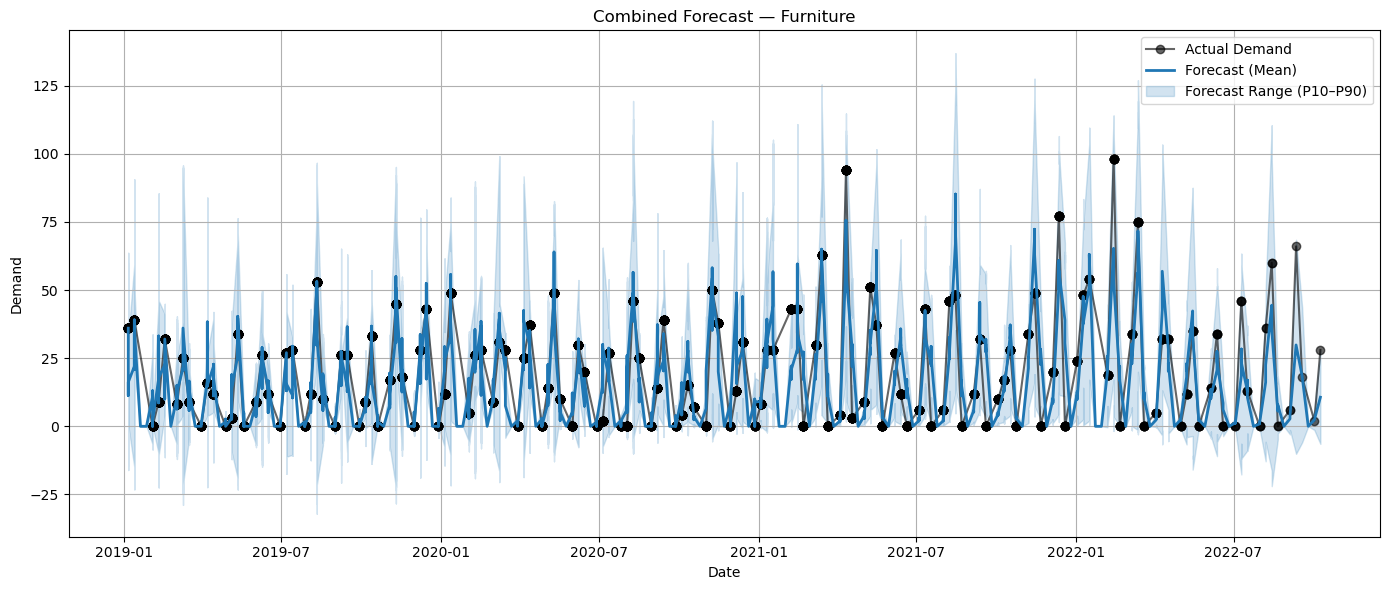


Combining and plotting all splits for: Office Supplies


/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_actual = pd.concat([all_actual, actual])
/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_mean = pd.concat([all_mean, summary["mean_forecast"]])
/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no

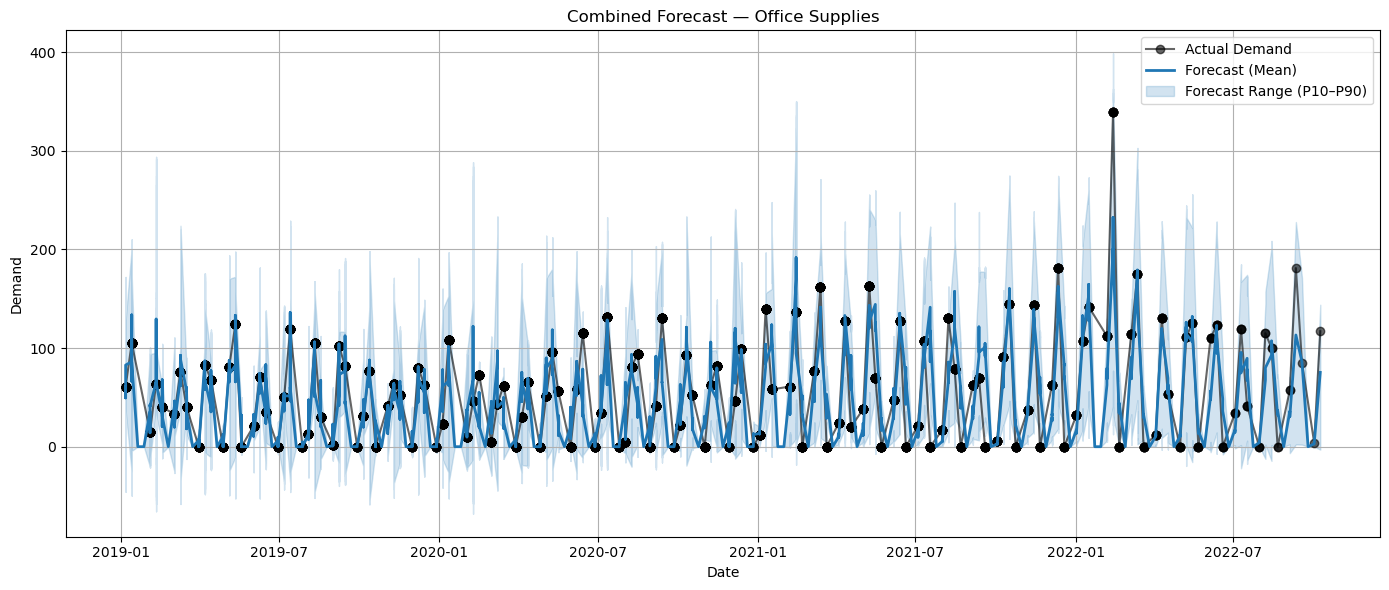


Combining and plotting all splits for: Technology


/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_actual = pd.concat([all_actual, actual])
/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_mean = pd.concat([all_mean, summary["mean_forecast"]])
/var/folders/qm/xr3xsq8s2hl_27kvzqb6mkz40000gn/T/ipykernel_15388/659282322.py:25: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no

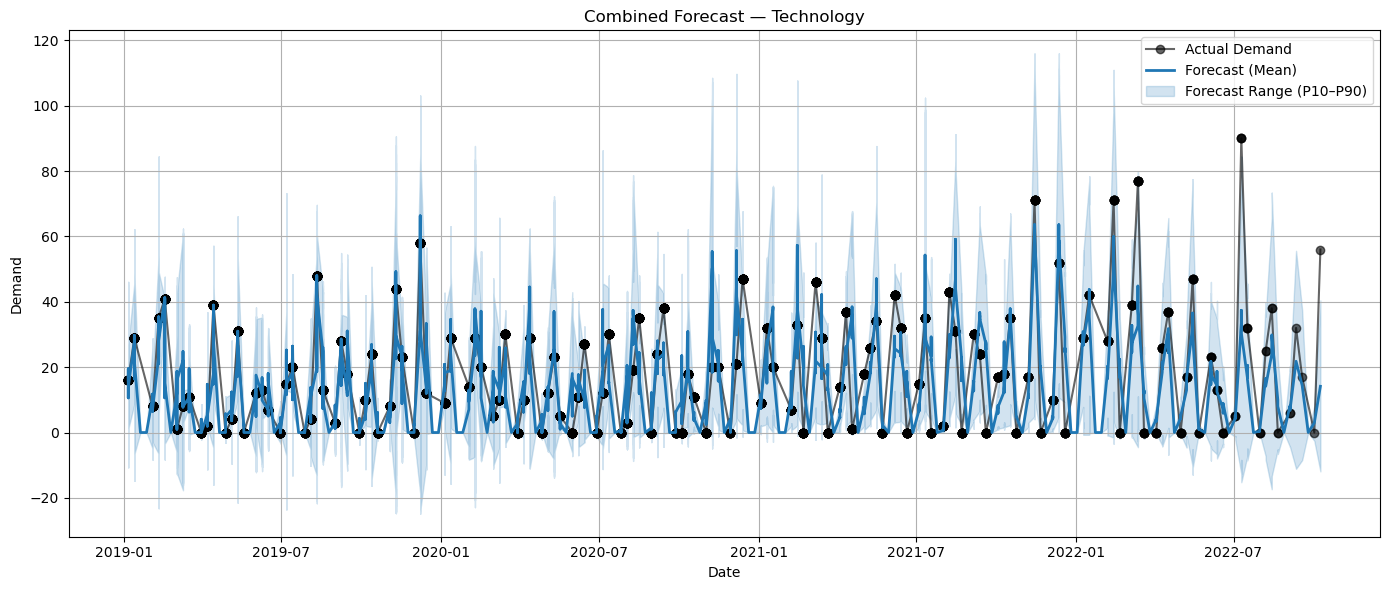

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

for cat in simulated_demands:
    print(f"\nCombining and plotting all splits for: {cat}")

    # Containers to collect all train actuals and simulation summaries
    all_actual = pd.Series(dtype=float)
    all_mean = pd.Series(dtype=float)
    all_p10 = pd.Series(dtype=float)
    all_p90 = pd.Series(dtype=float)

    for train_key in simulated_demands[cat]:
        if train_key not in seasonality_results[cat] or train_key not in monthly_summary[cat]:
            continue

        # Collect actuals
        train_df = seasonality_results[cat][train_key]["deseasonalized_train"]
        actual = train_df["quantity"]
        all_actual = pd.concat([all_actual, actual])

        # Collect forecast summary
        summary = monthly_summary[cat][train_key]
        all_mean = pd.concat([all_mean, summary["mean_forecast"]])
        all_p10 = pd.concat([all_p10, summary["p10"]])
        all_p90 = pd.concat([all_p90, summary["p90"]])

    # Sort by date (in case splits are not chronological)
    all_actual = all_actual.sort_index()
    all_mean = all_mean.sort_index()
    all_p10 = all_p10.sort_index()
    all_p90 = all_p90.sort_index()

    # Plot
    plt.figure(figsize=(14, 6))

    # Plot actual demand
    plt.plot(all_actual.index, all_actual.values, label="Actual Demand", color="black", linestyle="-", marker="o", alpha=0.6)

    # Plot forecast mean
    plt.plot(all_mean.index, all_mean.values, label="Forecast (Mean)", color="tab:blue", linewidth=2)

    # Plot forecast uncertainty band
    plt.fill_between(all_mean.index, all_p10.values, all_p90.values,
                     color="tab:blue", alpha=0.2, label="Forecast Range (P10–P90)")

    # Formatting
    plt.title(f"Combined Forecast — {cat}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Export result as Excel file

In [9]:
import pandas as pd

# Store results across categories
export_rows = []

for cat in simulated_demands:
    print(f"\nExporting WEEKLY forecast results for: {cat}")

    all_actual_list = []
    all_forecast_list = []

    for train_key in simulated_demands[cat]:
        if train_key not in seasonality_results[cat] or train_key not in monthly_summary[cat]:
            continue

        # Collect actuals (already weekly)
        train_df = seasonality_results[cat][train_key]["deseasonalized_train"].reset_index()
        actual = train_df[["date", "quantity"]].rename(columns={"quantity": "actual_demand"})
        all_actual_list.append(actual)

        # Collect forecast summary
        summary = monthly_summary[cat][train_key].reset_index()
        forecast = summary[["date", "mean_forecast", "p10", "p90"]].rename(
            columns={"mean_forecast": "forecast_demand"}
        )
        all_forecast_list.append(forecast)

    # Combine all actuals and forecasts
    all_actual_df = pd.concat(all_actual_list, ignore_index=True)
    all_forecast_df = pd.concat(all_forecast_list, ignore_index=True)

    # Merge them on date
    combined_df = pd.merge(all_actual_df, all_forecast_df, on="date", how="outer")

    # Aggregate in case of duplicate weeks from multiple splits
    combined_df = combined_df.groupby("date").agg({
        "actual_demand": "first",      # actuals should be identical for a given week
        "forecast_demand": "mean",     # average forecasts across splits
        "p10": "mean",
        "p90": "mean"
    }).reset_index()

    combined_df["category"] = cat
    combined_df["week"] = combined_df["date"].dt.isocalendar().week
    combined_df["year"] = combined_df["date"].dt.isocalendar().year

    # Arrange column order
    combined_df = combined_df[["category", "year", "week", "date", "actual_demand", "forecast_demand", "p10", "p90"]]

    export_rows.append(combined_df)

# Combine all categories
export_df = pd.concat(export_rows, ignore_index=True)

# Sort
export_df = export_df.sort_values(by=["category", "year", "week"]).reset_index(drop=True)

# Export
export_df.to_excel("weekly_forecast_table.xlsx", index=False)

print("\n Weekly forecast table exported to 'weekly_forecast_table.xlsx'")



Exporting WEEKLY forecast results for: Furniture

Exporting WEEKLY forecast results for: Office Supplies

Exporting WEEKLY forecast results for: Technology

 Weekly forecast table exported to 'weekly_forecast_table.xlsx'
